In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [43]:
def rgb2hsv(img):
    img = img/255
    hsv = np.zeros_like(img, dtype=np.float32)
    
    max_v = np.max(img,axis=2)
    min_v = np.min(img,axis=2)
    min_arg = np.argmin(img,axis=2)
    
    # Hの計算 ...は次元を省略して書く記法
    hsv[...,0][np.where(max_v==min_v)]=0
    ## if min == B
    ind = np.where(min_arg == 0)
    hsv[..., 0][ind] = 60 * (img[..., 1][ind] - img[..., 2][ind]) / (max_v[ind] - min_v[ind]) + 60
    ## if min == R
    ind = np.where(min_arg == 2)
    hsv[..., 0][ind] = 60 * (img[..., 0][ind] - img[..., 1][ind]) / (max_v[ind] - min_v[ind]) + 180
    ## if min == G
    ind = np.where(min_arg == 1)
    hsv[..., 0][ind] = 60 * (img[..., 2][ind] - img[..., 0][ind]) / (max_v[ind] - min_v[ind]) + 300
    
    # Sの計算
    hsv[...,1] = max_v-min_v
    
    # Vの計算
    hsv[...,2] = max_v
    
    return hsv

def hsv2rgb(img):
    max_v = np.max(img,axis=2)
    min_v = np.min(img,axis=2)
    rgb = np.zeros_like(img)
    
    C = img[...,1]
    Hdash = img[...,0]/60
    X = C * (1 - np.abs( Hdash % 2 - 1))
    Z = np.zeros_like(img[...,0])
    
    vals = [[Z,X,C], [Z,C,X], [X,C,Z], [C,X,Z], [C,Z,X], [X,Z,C]]

    for i in range(6):
        ind = np.where((i <= Hdash) & (Hdash < (i+1)))
        rgb[..., 0][ind] = (img[...,2] - C)[ind] + vals[i][0][ind]
        rgb[..., 1][ind] = (img[...,2] - C)[ind] + vals[i][1][ind]
        rgb[..., 2][ind] = (img[...,2] - C)[ind] + vals[i][2][ind]
    
    rgb[np.where(max_v == min_v)] = 0
    rgb = np.clip(rgb, 0, 1)
    rgb = (rgb * 255).astype(np.uint8)

    return rgb

def morphology_dilate(img):
    H,W = img.shape

    out = np.copy(img)
    for y in range(1,H-1):
        for x in range(1,W-1):
            if img[y,x]==0:
                tmp_l = [img[y-1,x],img[y,x-1],img[y,x+1],img[y+1,x]]
                if max(tmp_l) == 255:
                    out[y,x] = 255

    return out

def morphology_erode(img):
    H,W = img.shape

    out = np.copy(img)
    for y in range(1,H-1):
        for x in range(1,W-1):
            if img[y,x]==255:
                tmp_l = [img[y-1,x],img[y,x-1],img[y,x+1],img[y+1,x]]
                if min(tmp_l) == 0:
                    out[y,x] = 0
    
    return out

def opening(img,n_iter):
    out = img.copy()
    for i in range(n):
        out = morphology_erode(out)
        
    for i in range(n):
        out = morphology_dilate(out)
        
    return out

def closing(img,n_iter):
    out = img.copy()
    for i in range(n):
        out = morphology_dilate(out)
        
    for i in range(n):
        out = morphology_erode(out)
        
    return out

# カラートラッキング

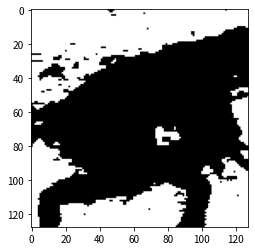

In [5]:
img = cv2.imread("./img/imori.jpg")

# 青色抜き出す処理
hsv_img = rgb2hsv(img)
mask = np.zeros_like(hsv_img[..., 0])
mask[np.logical_and((hsv_img[...,0]>=180),(hsv_img[...,0]<=260))] = 255

plt.imshow(cv2.cvtColor(mask.astype(np.uint8), cv2.COLOR_BGR2RGB)) 
plt.show()

# マスキング

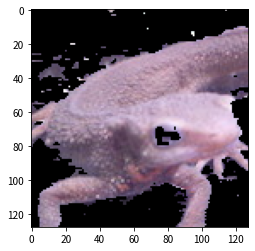

In [6]:
img = cv2.imread("./img/imori.jpg")

# マスク作成
hsv_img = rgb2hsv(img)
mask = np.zeros_like(hsv_img[..., 0])
mask[np.logical_and((hsv_img[...,0]>=180),(hsv_img[...,0]<=260))] = 1

mask = 1- mask
mask = np.tile(mask,(3,1,1)).transpose(1,2,0)
out = img*mask
out = out.astype(np.uint8)

plt.imshow(cv2.cvtColor(out, cv2.COLOR_BGR2RGB)) 
plt.show()

# マスキング(カラートラッキング+モルフォロジー)

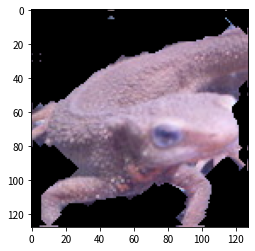

In [44]:
n=5
img = cv2.imread("./img/imori.jpg")

# マスク作成
hsv_img = rgb2hsv(img)
_mask = np.zeros_like(hsv_img[..., 0])
_mask[np.logical_and((hsv_img[...,0]>=180),(hsv_img[...,0]<=260))] = 255

mask = np.copy(_mask)
mask = closing(mask,n)
mask = opening(mask,n)
mask//=255
mask=1-mask
mask = np.tile(mask,(3,1,1)).transpose(1,2,0)
out = img*mask
out = out.astype(np.uint8)

plt.imshow(cv2.cvtColor(out, cv2.COLOR_BGR2RGB)) 
plt.show()